In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pandas as pd


In [9]:

dev_data_path = '/home/ashrafs/projects/dragon/data/fever/enriched_feverous_dev.jsonl'
dev_graph_path = '/home/ashrafs/projects/dragon/data/fever/feverous_dev_graph.pickle'
dev_graph_200nodes_path = '/home/ashrafs/projects/dragon/data/fever/dev_graph200nodes_path.pickle'  


In [10]:

def load_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Load the data
data_list = load_data(dev_data_path)

# Now, data_list contains all the data from the JSONL file
# Count the claims
number_of_claims = len(data_list)


In [11]:
number_of_claims

7890

In [13]:
def count_statements_per_claim(data_list):
    claim_data = []
    for data in data_list:
        claim_text = data.get('CLAIM', 'No Claim Found')
        entity_statements = data.get('ENTITY_STATEMENTS', {})

        # Count the number of statements for the current claim
        statement_count = sum(len(details.get('statements', [])) for _, details in entity_statements.items()) if entity_statements is not None else 0

        # Store both the claim text and the count in a tuple
        claim_data.append((claim_text, statement_count))

    return claim_data


In [14]:
# Assuming data_list contains your loaded data
claim_data = count_statements_per_claim(data_list)

# Convert to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(claim_data, columns=['Claim', 'Statement Counts'])

# Now df contains both the claim text and the corresponding statement counts


In [15]:
df.head(5)


,Claim,Statement Counts
0,Algebraic logic has five Logical system and Li...,96
1,Aramais Yepiskoposyan played for FC Ararat Yer...,828
2,Scot's book is titled The Discoverie of Witchc...,194
3,Family Guy is an American animated sitcom that...,5610
4,"In John Laurie's partial television credits, h...",0


In [16]:
# Find the index of the maximum and minimum Statement Counts
max_index = df['Statement Counts'].idxmax()
min_index = df['Statement Counts'].idxmin()

# Retrieve the rows corresponding to these indices
max_statement_row = df.loc[max_index]
min_statement_row = df.loc[min_index]

# Display the results
print("Row with Maximum Statement Count:\n", max_statement_row, "\n")
print("Row with Minimum Statement Count:\n", min_statement_row)


Row with Maximum Statement Count:
 Claim               4 the People was one of Malaysia's trendiest a...
Statement Counts                                                85996
Name: 4160, dtype: object 

Row with Minimum Statement Count:
 Claim               In John Laurie's partial television credits, h...
Statement Counts                                                    0
Name: 4, dtype: object


In [17]:
max_statement_row['Claim']


"4 the People was one of Malaysia's trendiest and highest grossing films in part due to Best Music Director winner Jassie Gift."

In [18]:
# Descriptive statistics
summary_statistics = df['Statement Counts'].describe()
print("Descriptive Statistics for Statement Counts:\n", summary_statistics)


Descriptive Statistics for Statement Counts:
 count     7890.000000
mean      1011.054499
std       2699.736381
min          0.000000
25%          0.000000
50%        565.000000
75%       1388.000000
max      85996.000000
Name: Statement Counts, dtype: float64


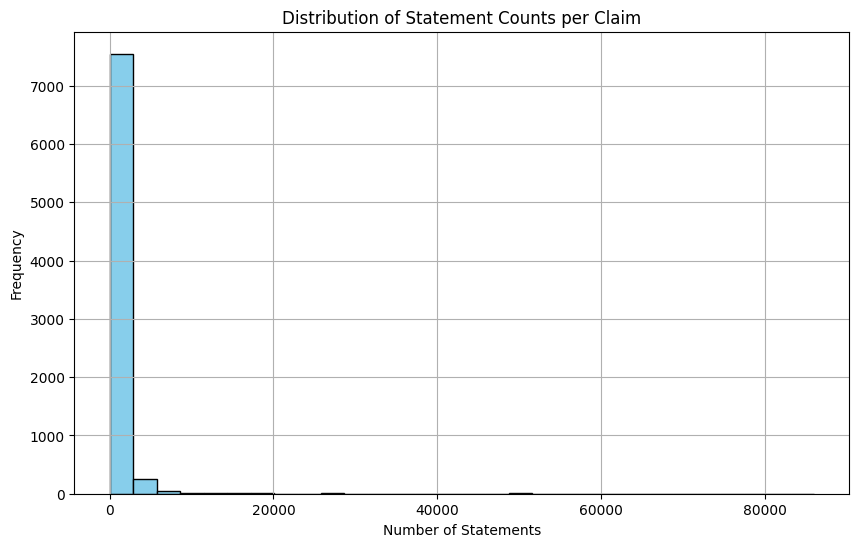

In [19]:
import matplotlib.pyplot as plt

# Histogram for statement counts
plt.figure(figsize=(10, 6))
plt.hist(df['Statement Counts'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Statement Counts per Claim')
plt.xlabel('Number of Statements')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [20]:
skewness = df['Statement Counts'].skew()
kurtosis = df['Statement Counts'].kurtosis()
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")


Skewness: 16.536293021327726
Kurtosis: 379.60749053516173


In [21]:
# Filter the DataFrame to get rows where 'Statement Counts' is 0
claims_with_zero_statements = df[df['Statement Counts'] == 0]

# Display these claims
print("Claims with Zero Statements:")
print(len(claims_with_zero_statements['Claim']))


Claims with Zero Statements:
2495


In [22]:
claims_with_zero_statements.head(5)

,Claim,Statement Counts
4,"In John Laurie's partial television credits, h...",0
5,"List of Once Upon a Time (debuted October 23, ...",0
8,Xiao Sha competed in the World Championships a...,0
9,"The Glenn–Thompson Plantation, a historic plan...",0
12,Harman Tarrant was a member of the first incar...,0


In [19]:

def is_fully_connected(G):
    return nx.is_connected(G.to_undirected()) if G.number_of_nodes() > 1 else False

claims_with_statements = [data for data in data_list if data.get('ENTITY_STATEMENTS') is not None and sum(len(details.get('statements', [])) for _, details in data.get('ENTITY_STATEMENTS', {}).items()) > 0]

graphs_stats = []

for data in claims_with_statements:
    G = nx.DiGraph()  # Using a directed graph
    entity_statements = data.get('ENTITY_STATEMENTS', {})

    for _, details in entity_statements.items():
        for statement in details.get('statements', []):
            # Add edges directly between entities, store relation as an edge attribute
            G.add_edge(statement[0], statement[2], relation=statement[1])

    num_nodes = G.number_of_nodes()
    fully_connected = is_fully_connected(G)
    
    graphs_stats.append({'Claim': data.get('CLAIM'), 'Num_Nodes': num_nodes, 'Is_Fully_Connected': fully_connected, 'Graph':G})

# Count of fully connected vs not fully connected graphs
fully_connected_count = sum(1 for stat in graphs_stats if stat['Is_Fully_Connected'])
not_fully_connected_count = sum(1 for stat in graphs_stats if not stat['Is_Fully_Connected'])

# Display the counts
print(f"Count of Fully Connected Graphs: {fully_connected_count}")
print(f"Count of Not Fully Connected Graphs: {not_fully_connected_count}")


Count of Fully Connected Graphs: 5283
Count of Not Fully Connected Graphs: 112


In [20]:

# Save the list of graphs to a file
with open(dev_graph_path, "wb") as f:
    pickle.dump(graphs_stats, f)


In [3]:
# Load the graphs from the file
with open(dev_graph_path, "rb") as f:
    loaded_graphs_stats = pickle.load(f)


In [4]:
# Print the keys of the first dictionary in loaded_graphs_stats
print(loaded_graphs_stats[0].keys())


dict_keys(['Claim', 'Num_Nodes', 'Is_Fully_Connected', 'Graph'])


In [5]:
len(loaded_graphs_stats)

5395

In [7]:
loaded_graphs_stats[0]

{'Claim': 'Algebraic logic has five Logical system and Lindenbaum–Tarski algebra which includes Physics algebra and Nodal algebra (provide models of propositional modal logics).',
 'Num_Nodes': 41,
 'Is_Fully_Connected': True,
 'Graph': <networkx.classes.digraph.DiGraph at 0x7f8e66a5fc70>}

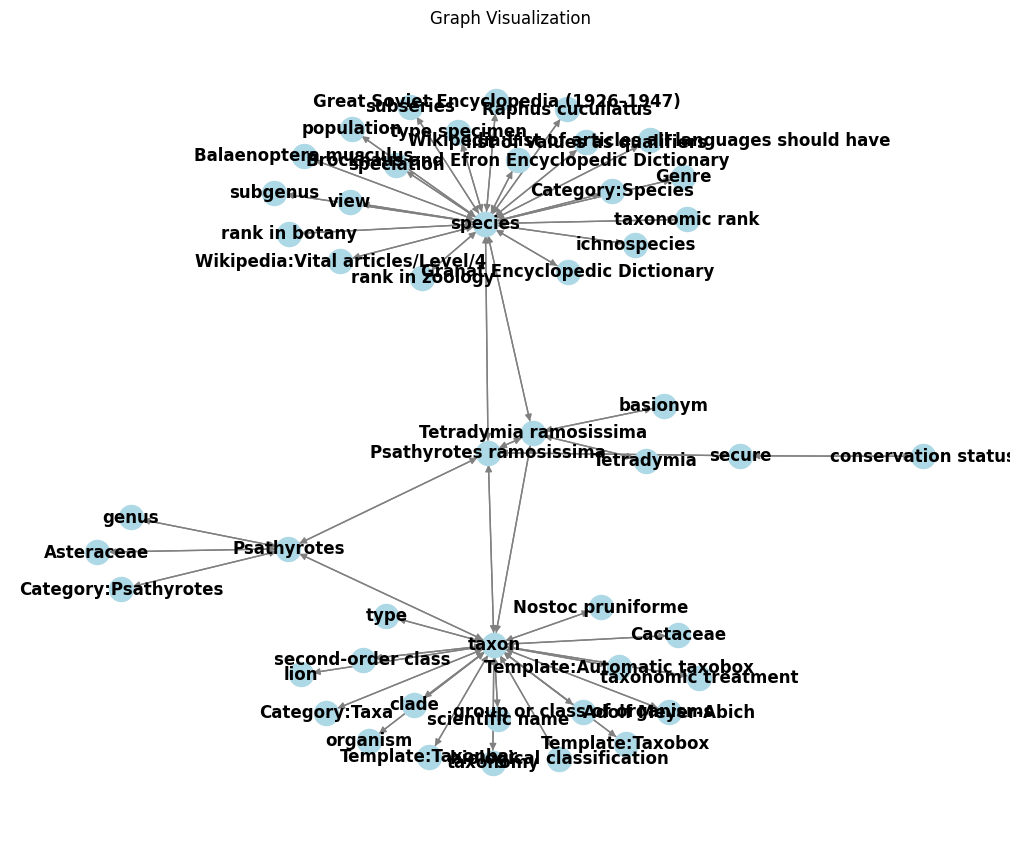

In [8]:
# Extract the first graph for demonstration purposes
example_graph = loaded_graphs_stats[50]['Graph']  # Replace 'Graph' with the actual key used for the graph
plt.figure(figsize=(10, 8))
nx.draw(example_graph, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')
plt.title("Graph Visualization")
plt.show()

In [30]:

def is_fully_connected(G):
    return nx.is_connected(G.to_undirected()) if G.number_of_nodes() > 1 else False

claims_with_statements = [data for data in data_list if data.get('ENTITY_STATEMENTS') is not None and sum(len(details.get('statements', [])) for _, details in data.get('ENTITY_STATEMENTS', {}).items()) > 0]

graphs_stats = []
max_nodes = 200  # Maximum number of nodes allowed

for data in claims_with_statements:
    G = nx.DiGraph()  # Using a directed graph
    entity_statements = data.get('ENTITY_STATEMENTS', {})

    for _, details in entity_statements.items():
        for statement in details.get('statements', []):
            # Check if the current number of nodes is less than the maximum allowed
            if G.number_of_nodes() < max_nodes:
                # Add edges directly between entities, store relation as an edge attribute
                G.add_edge(statement[0], statement[2], relation=statement[1])
            else:
                break  # Stop adding edges once the maximum number of nodes is reached

    num_nodes = G.number_of_nodes()
    fully_connected = is_fully_connected(G)
    
    graphs_stats.append({'Claim': data.get('CLAIM'), 'Num_Nodes': num_nodes, 'Is_Fully_Connected': fully_connected, 'Graph': G})

# Count of fully connected vs not fully connected graphs
fully_connected_count = sum(1 for stat in graphs_stats if stat['Is_Fully_Connected'])
not_fully_connected_count = sum(1 for stat in graphs_stats if not stat['Is_Fully_Connected'])

# Display the counts
print(f"Count of Fully Connected Graphs: {fully_connected_count}")
print(f"Count of Not Fully Connected Graphs: {not_fully_connected_count}")

# Save the list of graphs to a file
with open(dev_graph_200nodes_path, "wb") as f:
    pickle.dump(graphs_stats, f)



Count of Fully Connected Graphs: 5206
Count of Not Fully Connected Graphs: 189


In [26]:
filtered_data_list = [
    data for data in data_list 
    if data.get('ENTITY_STATEMENTS') is not None and 
       sum(len(details.get('statements', [])) for _, details in data.get('ENTITY_STATEMENTS', {}).items()) >= 1
]

dev_data = filtered_data_list


def construct_and_save_graphs_with_stats(data_subset, pickle_file_path):
    graphs_stats = []
    connectivity_stats = {
        'fully_connected': {'count': 0, 'total_nodes': 0},
        'not_fully_connected': {'count': 0, 'total_nodes': 0}
    }

    for data in data_subset:
        G = nx.DiGraph()  # Using a directed graph
        entity_statements = data.get('ENTITY_STATEMENTS', {})

        for _, details in entity_statements.items():
            for statement in details.get('statements', []):
                subject, _, obj = statement
                G.add_edge(subject, obj)  # Add edge without considering the relation

        num_nodes = G.number_of_nodes()
        fully_connected = is_fully_connected(G)

        # Append the graph's data
        graphs_stats.append({'graph': nx.adjacency_data(G), 'num_nodes': num_nodes, 'fully_connected': fully_connected})

        # Update connectivity stats with node counts
        if fully_connected:
            connectivity_stats['fully_connected']['count'] += 1
            connectivity_stats['fully_connected']['total_nodes'] += num_nodes
        else:
            connectivity_stats['not_fully_connected']['count'] += 1
            connectivity_stats['not_fully_connected']['total_nodes'] += num_nodes

    # # Save the graphs and stats to a pickle file
    # with open(pickle_file_path, "wb") as f:
    #     pickle.dump({'graphs_stats': graphs_stats, 'connectivity_stats': connectivity_stats}, f)

    return connectivity_stats

# Example usage
dev_data = filtered_data_list  # Ensure dev_data is defined and filtered for non-zero statements
dev_stats = construct_and_save_graphs_with_stats(dev_data, 'dev.graph.adj.pk')

# Print the connectivity statistics
print("Fully Connected Graphs Count:", dev_stats['fully_connected']['count'])
print("Total Nodes in Fully Connected Graphs:", dev_stats['fully_connected']['total_nodes'])
print("Not Fully Connected Graphs Count:", dev_stats['not_fully_connected']['count'])
print("Total Nodes in Not Fully Connected Graphs:", dev_stats['not_fully_connected']['total_nodes'])


Fully Connected Graphs Count: 5283
Total Nodes in Fully Connected Graphs: 3025265
Not Fully Connected Graphs Count: 112
Total Nodes in Not Fully Connected Graphs: 145894
